In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from typing import Optional, Tuple
import json
import os

In [4]:
IMAGES_DIR = '../data/VNIIGAZ_data/dataset_1/images'

In [26]:
labels_df = pd.read_csv('../data/VNIIGAZ_data/dataset_1/data.csv')

In [27]:
def get_coordinates(location: str) -> str:
    location = json.loads(location.replace("'", '"'))['data']
    location = [(vertex['x'], vertex['y']) for vertex in location]
    return location

In [36]:
import cv2
import matplotlib.pyplot as plt

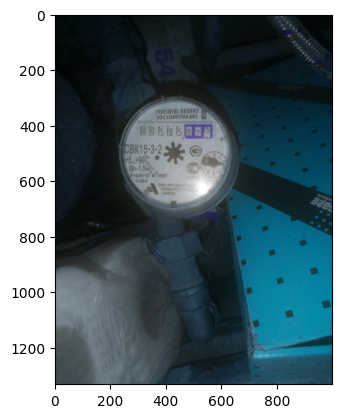

In [37]:
img = cv2.imread(os.path.join(IMAGES_DIR, 'id_53_value_595_825.jpg'))
plt.imshow(img)

In [ ]:
cv2.imshow(img)

In [28]:
labels_df['location'] = labels_df['location'].apply(lambda x: get_coordinates(x))

In [34]:
labels_df.head()

,photo_name,value,location
0,id_53_value_595_825.jpg,595.825,"[(0.30788, 0.30207), (0.30676, 0.32731), (0.53..."
1,id_553_value_65_475.jpg,65.475,"[(0.26133, 0.24071), (0.31405, 0.23473), (0.31..."
2,id_407_value_21_86.jpg,21.860,"[(0.27545, 0.19134), (0.37483, 0.18282), (0.38..."
3,id_252_value_313_322.jpg,313.322,"[(0.21967, 0.50845), (0.70811, 0.53256), (0.70..."
4,id_851_value_305_162.jpg,305.162,"[(0.06983, 0.43491), (0.34763, 0.42285), (0.34..."


In [44]:
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=20)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=20)

In [45]:
def convert_bbox_to_yolo_format(bbox: torch.Tensor, img_width: int, img_height: int) -> torch.Tensor:
    x_min, y_min, x_max, y_max = bbox
    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height

    return torch.tensor([x_center, y_center, width, height])
    

In [88]:
class MeterDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, 
                 img_dir: str, 
                 transform: Optional[transforms.Compose]=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.loc[idx, 'filename'])
        image = Image.open(img_name).convert('RGB')
        img_width, img_height = image.size
        bbox = self.dataframe.iloc[idx, 4:8] # x_min, y_min, x_max, y_max
        # поставить везде один класс
        label = self.dataframe.loc[idx, 'class']
        
        bbox = convert_bbox_to_yolo_format(torch.tensor(bbox, dtype=torch.float32), img_width, img_height)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label)
        return image, bbox, label

In [89]:
data_transforms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [90]:
train_dataset = MeterDataset(train_df, img_dir=IMAGES_DIR, transform=data_transforms)
val_dataset = MeterDataset(val_df, img_dir=IMAGES_DIR, transform=data_transforms)
test_dataset = MeterDataset(test_df, img_dir=IMAGES_DIR, transform=data_transforms)

In [91]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [92]:
next(iter(train_dataset))

C:\Users\Степан\AppData\Local\Temp\ipykernel_4412\660298160.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bbox = convert_bbox_to_yolo_format(torch.tensor(bbox, dtype=torch.float32), img_width, img_height)


(tensor([[[ 1.2899,  1.3413,  1.4269,  ..., -1.1075, -1.1075, -1.1075],
          [ 1.2385,  1.3070,  1.3927,  ..., -1.1075, -1.1075, -1.1075],
          [ 1.2043,  1.2728,  1.3413,  ..., -1.1075, -1.1075, -1.1075],
          ...,
          [-1.4329, -1.4329, -1.4329,  ...,  0.8447,  0.8447,  0.8447],
          [-1.4329, -1.4329, -1.4329,  ...,  0.8447,  0.8447,  0.8447],
          [-1.4329, -1.4329, -1.4329,  ...,  0.8447,  0.8447,  0.8447]],
 
         [[ 0.1877,  0.2402,  0.3277,  ..., -0.7577, -0.7577, -0.7577],
          [ 0.1352,  0.2052,  0.2927,  ..., -0.7577, -0.7577, -0.7577],
          [ 0.0826,  0.1527,  0.2577,  ..., -0.7577, -0.7577, -0.7577],
          ...,
          [-0.8277, -0.8277, -0.8277,  ...,  1.5182,  1.5182,  1.5182],
          [-0.8277, -0.8277, -0.8277,  ...,  1.5182,  1.5182,  1.5182],
          [-0.8277, -0.8277, -0.8277,  ...,  1.5182,  1.5182,  1.5182]],
 
         [[-0.4624, -0.4101, -0.3230,  ..., -0.5147, -0.5147, -0.5147],
          [-0.5147, -0.4450,